In [1]:
import yfinance as yf
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Input
from keras._tf_keras.keras.regularizers import L2

First, we need to format the data. Function format_data() takes a stock ticker as input and returns a dataframe with the stock's historical data, S&P500 data, and the target price.

In [2]:
def format_data(stock):
    stock_chosen = yf.Ticker(f"{stock}")
    stock_data = stock_chosen.history(start='2010-01-01', end='2024-09-01', interval="1d")
    
    stock_data.dropna(inplace=True)
    sp500_data = yf.download("^GSPC", start='2010-01-01', end='2024-09-01', interval="1d")
    sp500_data = sp500_data['Close'].rename('S&P500_Close')
    stock_data.index = stock_data.index.tz_localize(None)
    sp500_data.index = sp500_data.index.tz_localize(None)
    stock_data = stock_data.join(sp500_data, how='inner')
    stock_data = stock_data.drop(columns=["Dividends", "Stock Splits", "Volume", "Open"])
    features = ['Close', 'S&P500_Close']
    stock_data = stock_data[features].dropna()
    
    stock_data['Target'] = stock_data['Close'].shift(-1)
    stock_data.dropna(inplace=True)
    print(stock_data.columns)
    return stock_data

A call to format_data() with the stock ticker "AAPL" as the argument is made below.

In [3]:
stock_data = format_data("AAPL")

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'S&P500_Close', 'Target'], dtype='object')


Here, I am separating the features and target variables into X and Y.

In [4]:
features = ['Close', 'S&P500_Close']
X = stock_data[features]
Y = stock_data['Target']

print(X.head())
print(Y.head())

               Close  S&P500_Close
Date                              
2010-01-04  6.454505   1132.989990
2010-01-05  6.465665   1136.520020
2010-01-06  6.362819   1137.140015
2010-01-07  6.351059   1141.689941
2010-01-08  6.393280   1144.979980
Date
2010-01-04    6.465665
2010-01-05    6.362819
2010-01-06    6.351059
2010-01-07    6.393280
2010-01-08    6.336882
Name: Target, dtype: float64


Using keras, we can split the data into training and testing sets. 20% of the data will be used for testing and 80% for training.
In past iterations of this project, I failed to ensure that data was not shuffled, which outputted errors in my data. I set shuffle=False to make sure that the data is not shuffled.


In [14]:
X_training_set, X_testing_set, Y_training_set, Y_testing_set = train_test_split(X, Y, test_size=0.2, shuffle=False)

print(X_training_set.head())
print(X_testing_set.head())
print(Y_training_set.head()) 
print(Y_testing_set.head())


               Close  S&P500_Close
Date                              
2010-01-04  6.454505   1132.989990
2010-01-05  6.465665   1136.520020
2010-01-06  6.362819   1137.140015
2010-01-07  6.351059   1141.689941
2010-01-08  6.393280   1144.979980
                 Close  S&P500_Close
Date                                
2021-09-23  144.411758   4448.979980
2021-09-24  144.500305   4455.479980
2021-09-27  142.975800   4443.109863
2021-09-28  139.572784   4352.629883
2021-09-29  140.477646   4359.459961
Date
2010-01-04    6.465665
2010-01-05    6.362819
2010-01-06    6.351059
2010-01-07    6.393280
2010-01-08    6.336882
Name: Target, dtype: float64
Date
2021-09-23    144.500305
2021-09-24    142.975800
2021-09-27    139.572784
2021-09-28    140.477646
2021-09-29    139.169540
Name: Target, dtype: float64


A couple of graphs are plotted below to visualize the training and testing data:

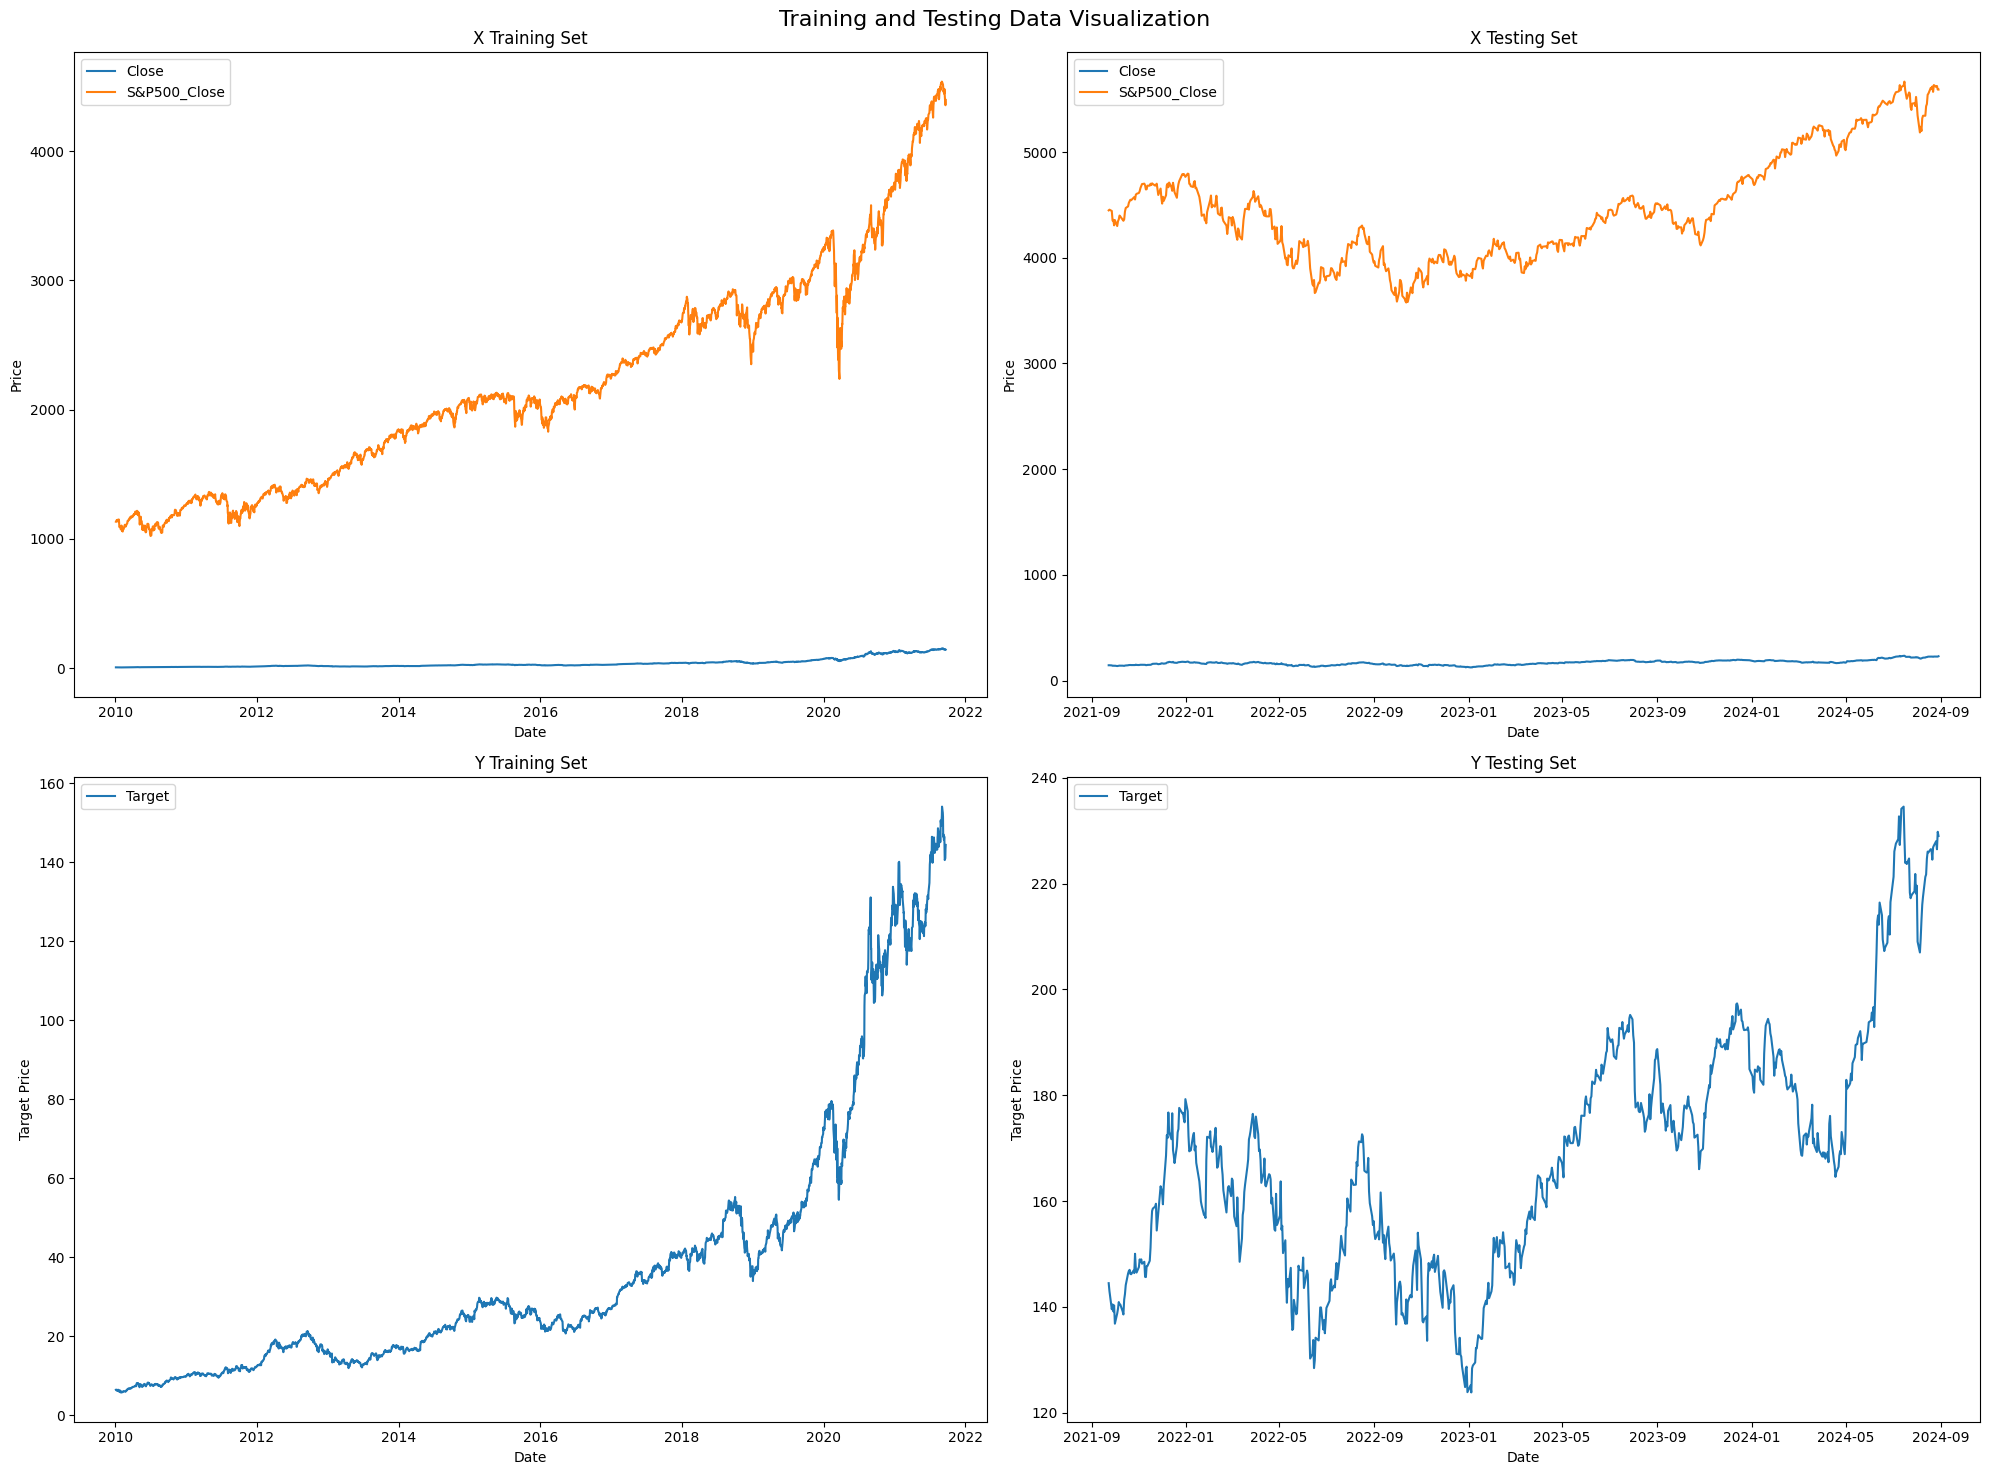

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Training and Testing Data Visualization', fontsize=16)

# Plot X_training_set
axs[0, 0].plot(X_training_set['Close'], label='Close')
axs[0, 0].plot(X_training_set['S&P500_Close'], label='S&P500_Close')
axs[0, 0].set_title('X Training Set')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')

# Plot X_testing_set
axs[0, 1].plot(X_testing_set['Close'], label='Close')
axs[0, 1].plot(X_testing_set['S&P500_Close'], label='S&P500_Close')
axs[0, 1].set_title('X Testing Set')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')

# Plot Y_training_set
axs[1, 0].plot(Y_training_set, label='Target')
axs[1, 0].set_title('Y Training Set')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Target Price')

# Plot Y_testing_set
axs[1, 1].plot(Y_testing_set, label='Target')
axs[1, 1].set_title('Y Testing Set')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Target Price')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In this next section, we scale the data. We use the MinMaxScaler from sklearn, which scales the data to a range of 0 to 1.

The current code that is not commented out is from a previous iteration of the project, where I attempted to scale the data using the same scaler for both X and Y. However, this caused a data leakage in my data, so I decided to scale the data separately for X and Y. The data was too accurate, and I was able to achieve a very low score. However, if this were to be true, it would be very easy to predict the stock price.

The commented out code is my attempt at scaling data using different scalers for X and Y, in order to prevent data leakage.

I have found that scaling the data separately for X and Y does not actually change the shape of the prediction - rather, the output is shifted down when using unique scalers for X and Y. With one scaler object, the RMSE is around 0.13, while with unique scalers, the RMSE is around 0.40


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_training_scaled = scaler.fit_transform(X_training_set)
Y_training_scaled = scaler.fit_transform(Y_training_set.values.reshape(-1, 1))

X_testing_scaled = scaler.fit_transform(X_testing_set)
Y_testing_scaled = scaler.fit_transform(Y_testing_set.values.reshape(-1, 1))

# X_scaler = MinMaxScaler(feature_range=(0, 1))
# Y_scaler = MinMaxScaler(feature_range=(0, 1))

# # Fit and transform on training data
# X_training_scaled = X_scaler.fit_transform(X_training_set)
# Y_training_scaled = Y_scaler.fit_transform(Y_training_set.values.reshape(-1, 1))

# # Only transform on testing data (no fitting)
# X_testing_scaled = X_scaler.transform(X_testing_set)
# Y_testing_scaled = Y_scaler.transform(Y_testing_set.values.reshape(-1, 1))

print(X_training_scaled.shape)
print(Y_training_scaled.shape)
print(X_testing_scaled.shape)
print(Y_testing_scaled.shape)
    


(2951, 2)
(2951, 1)
(738, 2)
(738, 1)


Now, I create sequences - a set of data points that are consecutive - for the data. For example, if the window size is 60, the sequence is the past 60 days of data. This is done for the training and testing data.

In [17]:
def create_sequences(X_data, Y_data, sequence_length=60):
    Xs, Ys = [], []
    for i in range(len(X_data) - sequence_length):
        Xs.append(X_data[i:(i + sequence_length)])
        Ys.append(Y_data[i + sequence_length])
    return np.array(Xs), np.array(Ys)

window_size = 60
features_no = 2 


X_training_seq, Y_training_seq = create_sequences(X_training_scaled, Y_training_scaled, window_size)  

X_testing_seq, Y_testing_seq = create_sequences(X_testing_scaled, Y_testing_scaled, window_size)

X_train = X_training_seq
X_test = X_testing_seq
Y_train = Y_training_seq
Y_test = Y_testing_seq

print(X_testing_seq.shape, Y_testing_seq.shape)
print(X_training_seq.shape, Y_training_seq.shape)
print(X_train.shape)
print(X_test.shape)


(678, 60, 2) (678, 1)
(2891, 60, 2) (2891, 1)
(2891, 60, 2)
(678, 60, 2)


Now, I create the model. I use LSTM layers, which are a type of RNN, and Dense layers. The model is compiled with the Adam optimizer and the mean squared error loss function. But before running the model, I make predictions on the testing data.

In [18]:
def createModel(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model


input_shape = (X_train.shape[1], X_train.shape[2])
model = createModel(input_shape)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Y_test = scaler.inverse_transform(Y_testing_seq)


model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)

/Users/danielliao/git/stock-prediction-model/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0072 - val_loss: 0.0979
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.5427e-04 - val_loss: 0.0461
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.9297e-04 - val_loss: 0.0202
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.5328e-04 - val_loss: 0.0125
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.0734e-04 - val_loss: 0.0110
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.5055e-04 - val_loss: 0.0201
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.7343e-04 - val_loss: 0.0206
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.7673e-04 - val_loss: 0.0259
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.3451e-04 - val_loss: 0.0325
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.1988e-04 - val_loss: 0.0256
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.7324e-04 - 

After the model is trained, I make predictions on the testing data.

In [19]:
lstm_stock_pred = model.predict(X_test)
lstm_stock_pred = scaler.inverse_transform(lstm_stock_pred)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Using root mean squared error, we can see how accurate the model is:

In [20]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))
    
return_rmse(Y_test, lstm_stock_pred)

The root mean squared error is 13.49.


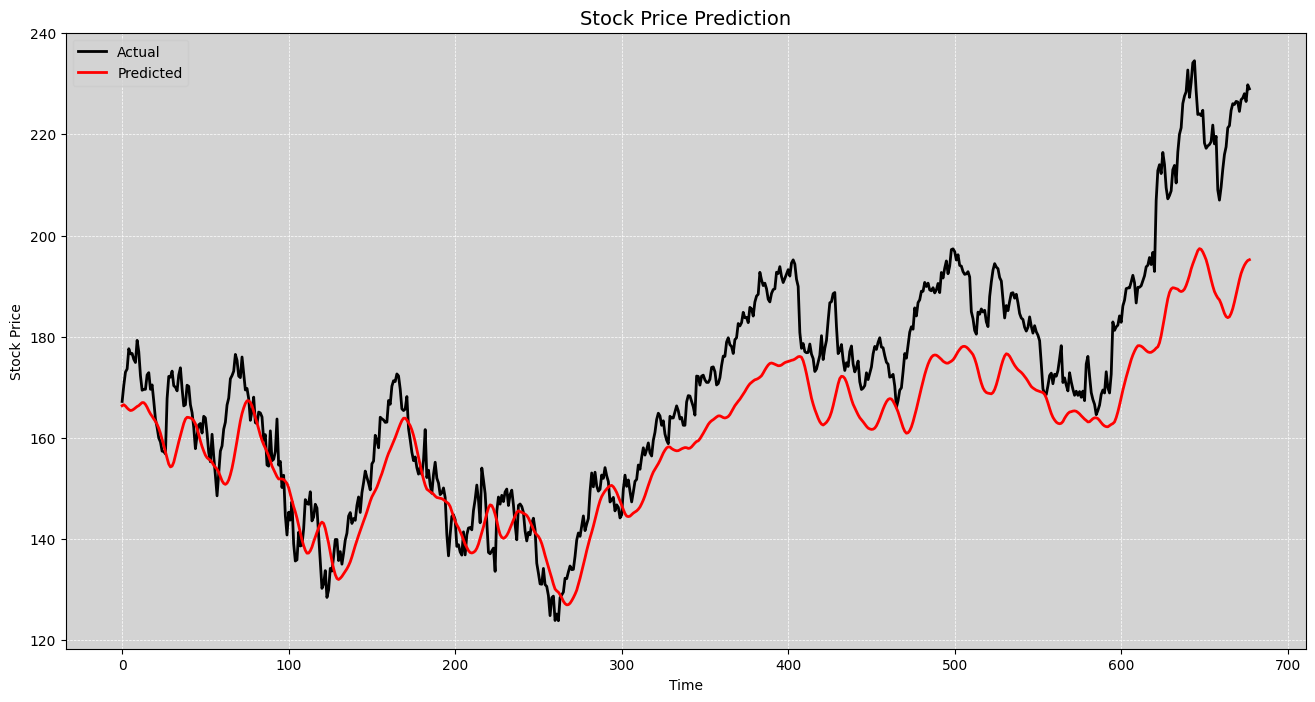

In [21]:
def plot_predictions(test, predicted):
    import matplotlib.pyplot as plt

    
    fig = plt.figure(figsize=(16, 8), facecolor='white')
    
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightgray')
    ax.plot(test, color='black', linewidth=2, label="Actual")
    ax.plot(predicted, color='red', linewidth=2, label="Predicted")
    leg = plt.legend(facecolor='lightgray')

    for text in leg.get_texts():
        text.set_color('black')

    plt.title("Stock Price Prediction", color='black', fontsize=14)
    plt.xlabel("Time", color='black', fontsize=10)
    plt.ylabel("Stock Price", color='black', fontsize=10)
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

    # Show the plot
plt.show()



def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


    
plot_predictions(Y_test,lstm_stock_pred)

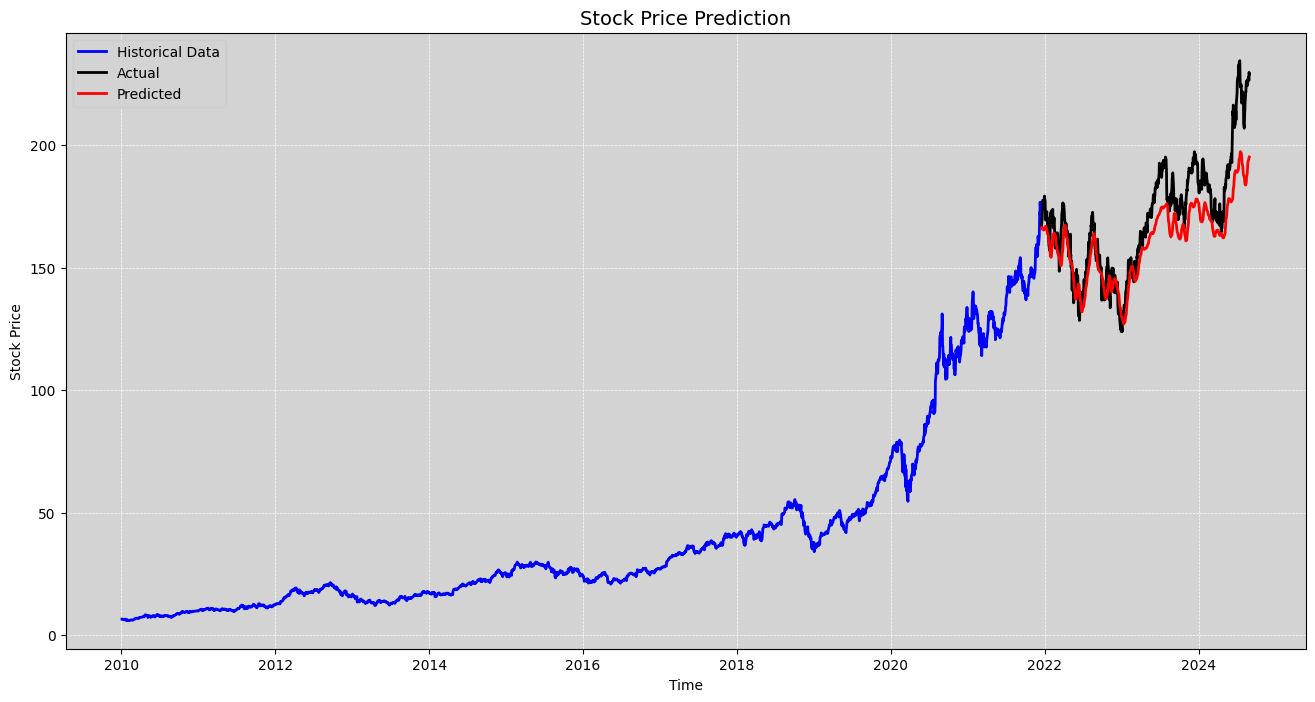

In [22]:
def plot_predictions(test, predicted, original_data):
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(16, 8), facecolor='white')
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightgray')
    
    # Plot original data
    original_end = len(original_data) - len(test)
    ax.plot(original_data.index[:original_end], original_data['Close'][:original_end], 
            color='blue', linewidth=2, label="Historical Data")
    
    # Plot actual test data
    ax.plot(original_data.index[original_end:], test, 
            color='black', linewidth=2, label="Actual")
    
    # Plot predicted data
    ax.plot(original_data.index[original_end:], predicted, 
            color='red', linewidth=2, label="Predicted")
    
    leg = plt.legend(facecolor='lightgray')
    for text in leg.get_texts():
        text.set_color('black')

    plt.title("Stock Price Prediction", color='black', fontsize=14)
    plt.xlabel("Time", color='black', fontsize=10)
    plt.ylabel("Stock Price", color='black', fontsize=10)
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

    plt.show()

# Call the function
plot_predictions(Y_test, lstm_stock_pred, stock_data)
